In [1]:
import numpy as np
from fenics import *
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import scipy.linalg as sla

## Poisson problem

$$\Delta u = 0$$

### BC's:
 - Left: Dirichlet $u = \sin(5 \pi x)$
 - Top and bottom: Neumann $\frac{du}{dn} = 0$
 - Right: Neumann $\frac{du}{dn} = 1$
 
### Weak form:

$$\int_\Omega \nabla u \cdot \nabla v dx = -\int_{\partial \Omega} 1 v dx$$

In [2]:
mesh_n = 20
mesh = UnitSquareMesh(mesh_n, mesh_n)
V = FunctionSpace(mesh, 'CG', 1)

Text(0.5, 1.0, 'solution')

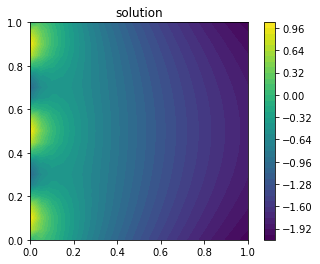

In [3]:
u_D_left = Expression('sin(omega*pi*x[1])', omega=5, degree=5)
u_N_right = Constant(1.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 1.0)
right = Right()
    
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
boundaries.set_all(0)
right.mark(boundaries, 1)

ds_custom = Measure('ds', subdomain_data=boundaries)


a = inner(grad(TestFunction(V)), grad(TrialFunction(V))) * dx
f = -TestFunction(V) * u_N_right * ds_custom(1)(mesh)

def left_boundary(x, on_boundary):
    return near(x[0], 0.0)

bc = DirichletBC(V, u_D_left, left_boundary)

A = assemble(a)
bc.apply(A)
A_solver = LUSolver(A)
F = assemble(f)
bc.apply(F)

u_soln = Function(V)
A_solver.solve(u_soln.vector(), F)
cm = plot(u_soln)
plt.colorbar(cm)
plt.title('solution')

### Solution via Lagrange multipliers / block matrices

$$\begin{aligned}\min_u &\quad \frac{1}{2}u^T A u \\
\text{such that}&\quad Bu = f\end{aligned} \quad \Leftrightarrow \quad \begin{bmatrix}A & B^T \\ B & 0\end{bmatrix}\begin{bmatrix}u \\ \lambda\end{bmatrix} = \begin{bmatrix}0 \\ f\end{bmatrix}$$


 - $$A_{ij} := \int_\Omega \nabla \phi_i \cdot \nabla \phi_j dx$$

 - $$B_{ij} := \int_{\partial \Omega} \phi_i \left(\nu \cdot \nabla \phi_j\right) ds$$
 
 - $$f_i = \int_{\partial \Omega} 1 \phi_i ds$$
 
 - $\nu$ is normal vector to boundary

In [5]:
def convert_fenics_csr_matrix_to_scipy_csr_matrix(A_fenics):
    ai, aj, av = as_backend_type(A_fenics).mat().getValuesCSR()
    A_scipy = sps.csr_matrix((av, aj, ai))
    return A_scipy

In [6]:
A_scipy = convert_fenics_csr_matrix_to_scipy_csr_matrix(A)

nu = FacetNormal(mesh)
b = TestFunction(V) * inner(nu, grad(TrialFunction(V))) * ds_custom(1)(mesh)
B0 = assemble(b)
B0_scipy = convert_fenics_csr_matrix_to_scipy_csr_matrix(B0)

z = B0 * np.random.randn(V.dim())
nonzero_rows = np.where(np.abs(z) > 1e-13)[0]

# nonzero_rows = B0_scipy.nonzero()[0]

B = B0_scipy[nonzero_rows, :]
_, ssB, B = np.linalg.svd(B.toarray(), full_matrices=False)
B = B[:-2, :]

In [8]:
A2_scipy = A_scipy.copy()
A2_scipy[nonzero_rows, :] = B0_scipy[nonzero_rows, :]

array([7.95141214e+00, 7.87912894e+00, 7.87912336e+00, 7.80691078e+00,
       7.76058689e+00, 7.76057672e+00, 7.68850694e+00, 7.68845820e+00,
       7.59863962e+00, 7.59861829e+00, 7.57024538e+00, 7.52672388e+00,
       7.52665438e+00, 7.40880693e+00, 7.40862086e+00, 7.39717490e+00,
       7.39714833e+00, 7.32548505e+00, 7.32535821e+00, 7.24754232e+00,
       7.20788931e+00, 7.20765850e+00, 7.16104761e+00, 7.16100326e+00,
       7.08959457e+00, 7.08945012e+00, 7.04729373e+00, 7.04680868e+00,
       6.97245410e+00, 6.97207095e+00, 6.89592729e+00, 6.89587938e+00,
       6.84712586e+00, 6.82478302e+00, 6.82455831e+00, 6.81233994e+00,
       6.81179376e+00, 6.70805673e+00, 6.70764851e+00, 6.61331695e+00,
       6.61229882e+00, 6.60820497e+00, 6.60814629e+00, 6.54867871e+00,
       6.54783633e+00, 6.53736470e+00, 6.53713543e+00, 6.42122141e+00,
       6.42062270e+00, 6.37928019e+00, 6.35025117e+00, 6.34920264e+00,
       6.30483541e+00, 6.30476823e+00, 6.26241391e+00, 6.26156492e+00,
      

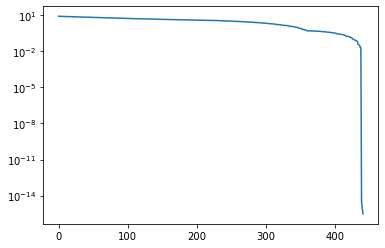

In [12]:
_,ss,_ = np.linalg.svd(A2_scipy.toarray())
plt.semilogy(ss)
ss

err= 0.9967849541687099


Text(0.5, 1.0, 'solution via block matrices')

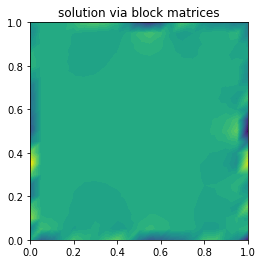

In [50]:
K = sps.bmat([[A_scipy, B.T],
              [B, None]]).tocsr()
y = np.concatenate([np.zeros(V.dim()), F[nonzero_rows][:-2]])

x = spla.spsolve(K,y)
u_soln2 = Function(V)
u_soln2.vector()[:] = x[:V.dim()].copy()

err = np.linalg.norm(u_soln.vector()[:] - u_soln2.vector()[:])/np.linalg.norm(u_soln.vector()[:])
print('err=', err)
                                                                              
plot(u_soln2)
plt.title('solution via block matrices')

(80, 441)

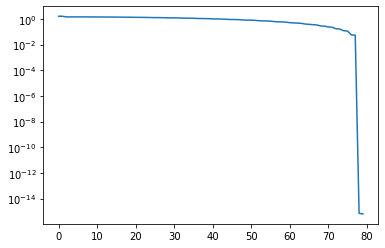

In [33]:
_,ss,_ = np.linalg.svd(B.toarray())
plt.semilogy(ss)
B.shape

In [23]:
V.dim()

441

## Augmented Lagrangian preconditioner:
$$K = \begin{bmatrix}A & B^T \\ B & 0\end{bmatrix}$$

$$P = \begin{bmatrix}A + \rho B^T M^{-1} B & 0 \\ 0 & \frac{1}{\rho} M\end{bmatrix}$$

Generalized eigenvalue problem: $K z = \mu P z$. Eigenvalues $\mu$ clustered around $\pm 1$

 - $M$ is (lumped) mass matrix
 - $\rho\approx 1$ is penalty parameter

In [ ]:
rho = 1e0

M = assemble(TestFunction(V) * TrialFunction(V) * dx)
M_scipy = convert_fenics_csr_matrix_to_scipy_csr_matrix(M)

M_dense = M_scipy.toarray() # dense matrices for rapid prototyping; don't use dense in real problem
K_dense = K.toarray()
A_dense = A_scipy.toarray()
B_dense = B_scipy.toarray()

ML_dense = np.diag(M_dense.diagonal())
iML_dense = np.diag(1./M_dense.diagonal())


P11 = A_dense + rho * np.dot(B_dense.T, np.dot(iML_dense, B_dense))
P12 = np.zeros((V.dim(), V.dim()))
P21 = np.zeros((V.dim(), V.dim()))
P22 = (1./rho) * ML_dense
P = np.bmat([[P11, P12],
             [P21, P22]])

ee, _ = sla.eigh(K_dense, P)
plt.plot(ee)
plt.title('eigenvalues for generalized eigenvalue problem of K and P')